In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pdb
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold


sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings

from loaders import load_peanut
from decoders import lr_decoder

In [6]:
with open('/mnt/Secondary/data/postprocessed/sabes_M1subtrunc_svm_df.pkl', 'rb') as f:
    rl = pickle.load(f)
df = pd.DataFrame(rl)

# Filter by start time truncation only
filt = [idx for idx in range(df.shape[0]) 
        if df.iloc[idx]['loader_args']['subset'] is None and df.iloc[idx]['loader_args']['truncate_start'] is True]
df = df.iloc[filt]

data_files = np.unique(df['data_file'].values)
dims = np.unique(df['dim'].values)

r2fc = np.zeros((len(data_files), dims.size, 5))
r2pca = np.zeros((len(data_files), dims.size, 5))

for i, data_file in tqdm(enumerate(data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
            assert(dim_fold_df.shape[0] == 1)
            r2fc[i, j, f] = dim_fold_df.iloc[0]['r2'][1]
            pca_df = apply_df_filters(df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='PCA')
            assert(pca_df.shape[0] == 1)
            r2pca[i, j, f] = pca_df.iloc[0]['r2'][1]

35it [00:12,  2.70it/s]


NameError: name 'dims' is not defined

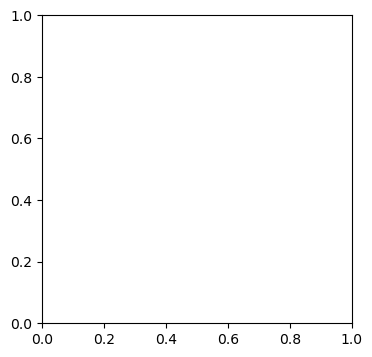

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red', '#781820', '#5563fa']
dim_vals = dims

# # DCA averaged over folds
# dca_r2 = np.nanmean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.nanmean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.nanmean(r2fc[:, ::2, :], axis=2)
# PCA
pca_r2 = np.nanmean(r2pca[:, ::2, :], axis=2)
ax.fill_between(dim_vals[::2], np.nanmean(fca_r2, axis=0) + np.nanstd(fca_r2, axis=0)/np.sqrt(35),
                np.nanmean(fca_r2, axis=0) - np.nanstd(fca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
ax.plot(dim_vals[::2], np.nanmean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals[::2], np.nanmean(pca_r2, axis=0) + np.nanstd(pca_r2, axis=0)/np.sqrt(35),
                np.nanmean(pca_r2, axis=0) - np.nanstd(pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
ax.plot(dim_vals[::2], np.nanmean(pca_r2, axis=0), color=colors[0])
fig.savefig('/home/akumar/nse/neural_control/figs/revisions/SVMdecoding.pdf', bbox_inches='tight', pad_inches=0)